## Closing the water balance using remote sensing data

*ENVM1502* - March 2025

### Introduction

Consider the monthly water balance for a river basin:

$$S_t = S_{t-1} + P_t - E_t - Q_t$$

Here, $S_{t−1}$ and $S_t$ are total water storage (surface and subsurface) in the basin at the start and end of month $t$, $P_t$ and $E_t$ are basin average precipitation and evaporation (including transpiration), and $Q_t$ is river discharge at the basin outlet for month $t$. Each term is normalized by basin area and expressed in consistent water depth units (e.g. mm). For simplicitiy, lateral groundwater flow into or out of the basin is ignored, as are inter-basin water transfers.

We can obtain independent estimates for each of the water balance components, e.g. from satellite data (water storage, precipitation, evaporation) and from ground-based observations (river discharge). However, bringing these multi-source data together into the basin-scale water balance equation typically leads to significant water balance errors: in any particular month, we end up with either too much or too little water.  

The reason the water balance does not close is that each dataset contains errors, both systematic ("bias") and random ("noise"). In principle, the underlying unknown "true" (error-free) water balance variables should close the water balance. As such, to compensate for data errors, we could make adjustments to the original data values to bring them closer to their true values until we obtain a set of values that closes the water balance. In this setup, data with large errors can in principle be adjusted more than data with small errors.

In this notebook you will implement a methodology, based on `data assimilation`, that enables automatic bias-correction and noise-filtering of water balance data, resulting in hydrologically consistent water balance estimates that close the water balance. 

The notebook consists of three parts:
1. *Errors in water balance data*: introduces the monthly water balance data for the case study river basin and defines probabilistic models to describe errors in the data.
2. *Uncertainty propagation and Gaussian product*: introduces the two basic building blocks for doing data assimilation by looking at a single month.
3. *Kalman filtering and smoothing*: incorporates the building blocks from part 2 into a data assimilation algorithm that loops over all months.

In [1]:
# useful imports
from scipy.stats import norm#the normal distribution
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Part 1: Errors in water balance data

### Case study: Lake Burragorang, Australia

We'll use water balance data for the semi-arid Mond river basin in Iran. The data are provided as text files containing monthly values in mm (basin averages), covering a period of ten years (Jan 2006 - Dec 2015). Let's explore the data by plotting them and setting up probabilistic models for the data errors.

#### Precipitation data

Three precipitation time-series are provided: `imerg.txt` (precipitation from [GPM IMERG](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_MONTHLY_V06)), `era5P.txt` (precipitation from [ERA5](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR)), `chirps.txt` (precipitation from [CHIRPS](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)).

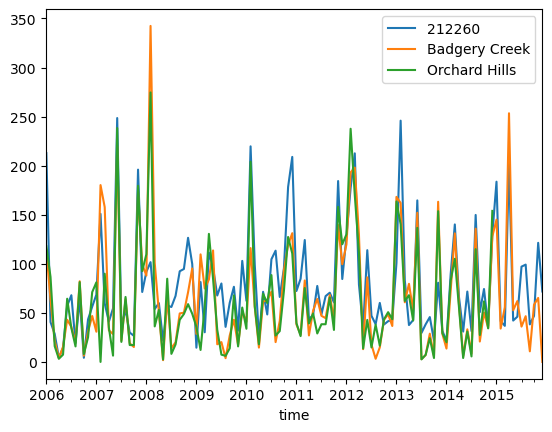

In [2]:
# Read and plot the monthly precipitation data
"Unfortunately The Warrangamba Station at the Warrangamba Dam does not have reliable data, so weather stations further east were used."
#Load in Camel Precipitation Data
df_camel = pd.read_csv('../../Data/Prep_Camel_SILO.csv')
df_camel['time'] = pd.to_datetime(df_camel[['year', 'month', 'day']])
df_camel.drop(['day', 'year', 'month'], axis= 1, inplace = True)
df_camel.set_index('time', inplace=True)
df_camel = df_camel['212260']
df_camel = df_camel['2006': '2015']
df_camel_month = df_camel.resample('ME').sum()

#Load in BOM Data
df = pd.read_csv('../../Data/Badgery_Creek_Prep.csv', usecols=[2,3,4,5])
df['time'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.drop(['Day', 'Year', 'Month'], axis= 1, inplace = True)
df.dropna(axis= 0, inplace=True)
df.set_index('time', inplace=True)
df.rename(columns={'Rainfall amount (millimetres)':'Badgery Creek'}, inplace=True)
df = df['2006': '2015']
df_monthly = df.resample('ME').sum()

df_hill = pd.read_csv('../../Data/Orchard_Hills_Prep.csv', usecols=[2,3,4,5])
df_hill['time'] = pd.to_datetime(df_hill[['Year', 'Month', 'Day']])
df_hill.drop(['Day', 'Year', 'Month'], axis= 1, inplace = True)
df_hill.dropna(axis= 0, inplace=True)
df_hill.set_index('time', inplace=True)
df_hill.rename(columns={'Rainfall amount (millimetres)':'Orchard Hills'}, inplace=True)
df_hill = df_hill['2006': '2014']
df_hill_monthly = df_hill.resample('ME').sum()

df_P = pd.concat([df_camel_month, df_monthly, df_hill_monthly], axis = 1)

df_P.plot()
plt.show()



In any given month, there are clearly differences in precipitation between the datasets, especially for wet months. A common approach is to use the variation between datasets to characterize data errors: large spread between datasets suggests large error and uncertainty. The simplest implementation of this idea is to use the mean and variance across the datasets to characterize precipitation uncertainty. Note however that this is by no means the only or best approach - it is an open research question how to characterize errors in precipitation (and other) datasets. 

In each month, the sample mean $m$ and variance $v$ across $N$ datasets can be computed as:

$$m = \frac{1}{N}\sum_{i=1}^N x_i$$
$$v = \frac{1}{N-1}\sum_{i=1}^N (x_i - m)^2$$

If we apply these equations to the three precipitation datasets, we get monthly values of $m_P$ and $v_P$, which we interpret as mean and variance of a normal (Gaussian) distribution $\mathcal{N}(P|m_P, v_P)$ for the precipitation errors (uncertainty) in each month.

In [3]:
# Compute monthly mean mP and variance vP of precipitation

row_mean = df_P.mean(axis=1)
row_variance = df_P.var(axis=1)

df_meep = pd.DataFrame({ 'Mean': row_mean, 'Var': row_variance})


df_meep


,Mean,Var
time,,
2006-01-31,148.318530,3117.711069
2006-02-28,63.542180,528.404899
2006-03-31,22.040724,39.509087
2006-04-30,3.776886,0.319998
2006-05-31,12.359718,18.763178
...,...,...
2015-08-31,72.876165,1380.873680
2015-09-30,24.521114,376.537950
2015-10-31,52.534814,64.188662


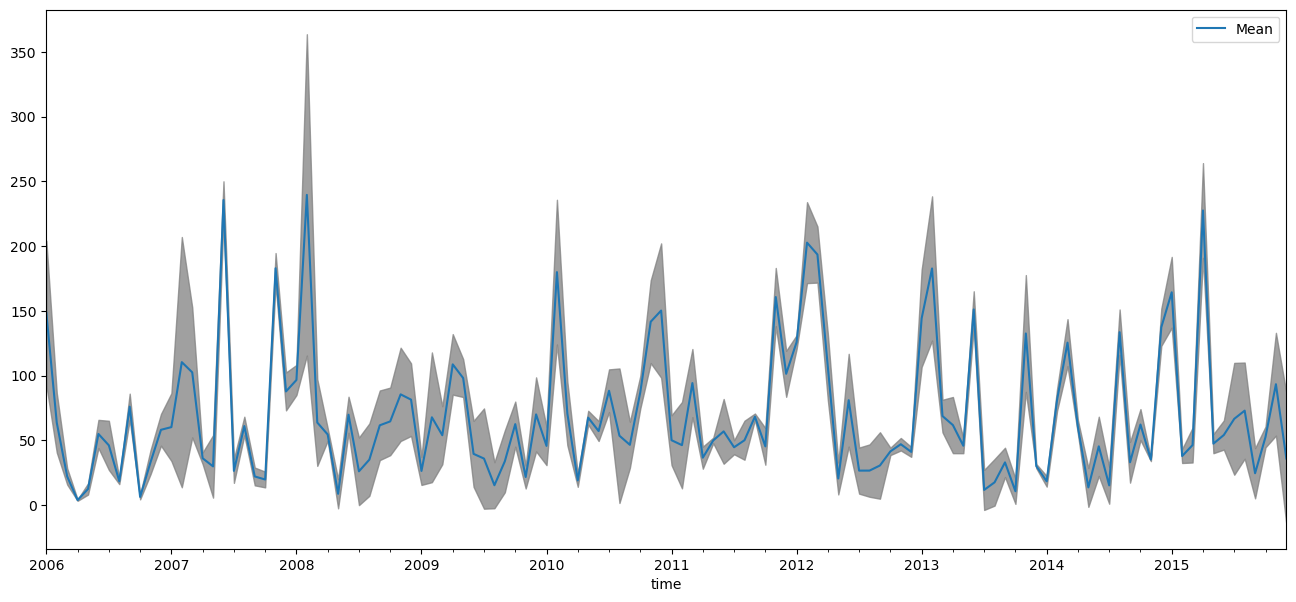

In [4]:
# Plot monthly mean and uncertainty interval (+-sigma) of precipitation.
# The plt.fill_between() function is useful for plotting an uncertainty interval.

df_meep['Low_int'] = df_meep['Mean'] - np.sqrt(df_meep['Var'])
df_meep['High_int'] = df_meep['Mean'] + np.sqrt(df_meep['Var'])

fig, ax = plt.subplots(figsize=(16,7))
df_meep['Mean'].plot(ax =ax , label = 'Mean')
ax.fill_between(df_meep.index, df_meep['Low_int'], df_meep['High_int'], color='gray', alpha=0.75)
ax.legend()
plt.show()

#### Evaporation data

Three evaporation time-series are provided: `gleam.txt` (actual evaporation from [GLEAM](https://www.gleam.eu/)), `eraE.txt` (actual evaporation from [ERA5](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR)), `mod16.txt` (actual evaporation from [MODIS](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2)).

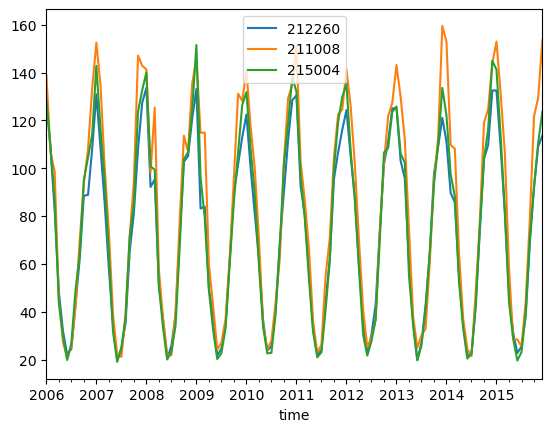

In [5]:
# Read and plot the monthly evaporation data
df_E = pd.read_csv('../../Data/et_morton_actual_SILO.csv')
df_E['time'] = pd.to_datetime(df_E[['year', 'month', 'day']])
df_E.drop(['day', 'year', 'month'], axis= 1, inplace = True)
df_E.set_index('time', inplace=True)
df_E = df_E[['212260', '211008', '215004']]#Unfortunately the Australian Bureau of Meteorology does not provide any evaporation data. 
#These are the closest stations to Lake Burragorang with Camel Actual Evaporation Data.
df_E = df_E['2006': '2015']
df_E = df_E.resample('ME').sum()

#df_E = pd.concat([df_gleam, df_era5e, df_mod16], axis = 1)

df_E.plot()
plt.show()

Again, we see large discrepancies between the datasets, especially in the dry summer months, when the different datasets disagree on the degree of water stress (reduction from potential ET rate).

Let's use the same approach as for precipitation to characterize uncertainty in monthly evaporation, yielding a Gaussian distribution $\mathcal{N}(E|m_E, v_E)$ in each month.

In [6]:
# Compute monthly mean mE and variance vE of evaporation
row_mean = df_E.mean(axis=1)
row_variance = df_E.var(axis=1)

df_meee = pd.DataFrame({ 'Mean': row_mean, 'Var': row_variance})

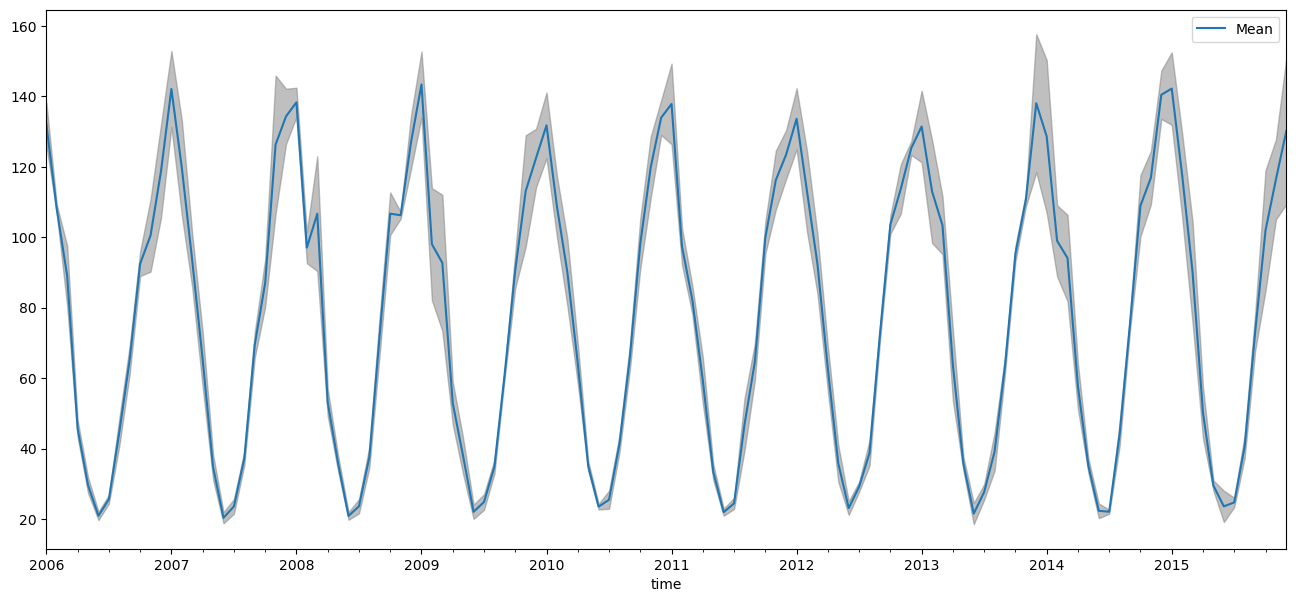

In [7]:
# Plot monthly mean and uncertainty interval (+-sigma) of evaporation
df_meee['Low_int'] = df_meee['Mean'] - np.sqrt(df_meee['Var'])
df_meee['High_int'] = df_meee['Mean'] + np.sqrt(df_meee['Var'])


fig, ax = plt.subplots(figsize=(16,7))
df_meee['Mean'].plot(ax =ax , label = 'Mean')
ax.fill_between(df_meee.index, df_meee['Low_int'], df_meee['High_int'], color='grey', alpha=0.5)
ax.legend()
plt.show()

#### River discharge data

The provided file `runoff.txt` contains monthly river discharge (mm) from a stream gauge at the river basin outlet. 

In [8]:
# Read and plot the monthly river discharge data

df_212270 = pd.read_csv('../../Data/Inflow/212270.csv', index_col=0, usecols= [1,2], parse_dates=True)
df_212270.index = df_212270.index.date
df_212270.rename(columns={'Flow Rate (ML/day)': '212270'}, inplace= True)

df_212260 = pd.read_csv('../../Data/Inflow/212260.csv', index_col=0, usecols= [1,2], parse_dates=True)
df_212260.index = df_212260.index.date
df_212260.rename(columns={'Flow Rate (ML/day)': '212260'}, inplace= True)

df_212250 = pd.read_csv('../../Data/Inflow/212250.csv',index_col=0, usecols= [1,2], parse_dates=True)
df_212250.index = df_212250.index.date
df_212250.rename(columns={'Flow Rate (ML/day)': '212250'}, inplace= True)

df_212280 = pd.read_csv('../../Data/Inflow/212280.csv', index_col=0, usecols= [1,2], parse_dates=True)
df_212280.index = df_212280.index.date
df_212280.rename(columns={'Flow Rate (ML/day)': '212280'}, inplace= True)


df_discharge = pd.concat([df_212250, df_212260, df_212270, df_212280], axis = 1, join='outer')
df_discharge.index = pd.to_datetime(df_discharge.index)
df_discharge = df_discharge.resample('D').max()

def fill_nan_with_rolling_mean(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, forcing errors to NaN
        nan_indices = df[df[col].isna()].index  # Get indices of NaN values
        for idx in nan_indices:
            # Select the last 7 valid (non-NaN) values based on the DateTime index
            prior_values = df[col].loc[:idx].dropna().rolling('30D').mean()
            if not prior_values.empty:
                df.at[idx, col] = prior_values.iloc[-1]  # Use last calculated mean
    return df
df_discharge_filled = fill_nan_with_rolling_mean(df_discharge)

df_discharge_filled.index= pd.to_datetime(df_discharge_filled.index)
df_discharge_filled = df_discharge_filled['2006' :'2015']
df_discharge_filled.dropna(how = 'any',axis = 0, inplace=True)
df_discharge_filled_test = df_discharge_filled.copy()
df_discharge_filled_test['Q_sum [ML/d]'] = df_discharge_filled.sum(axis = 1)



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_35348\989233802.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge_filled.dropna(how = 'any',axis = 0, inplace=True)


Uncertainty and errors in river discharge measurements can in principle be estimated using a rating curve error analysis. Here, we will assume a 10% relative error in each month, reflecting the common situation of greater errors for measuring larger flow rates. This assumption allows us to compute a Gaussian distribution $\mathcal{N}(Q|m_Q, v_Q)$ for river discharge uncertainty in each month, where $m_Q$ is equal to the discharge measurement (unbiased measurement) and $v_Q$ is computed from the 10% error assumption.

In [9]:
meed = df_discharge_filled_test['Q_sum [ML/d]'].resample('ME').sum()
df_meed = pd.DataFrame({'Discharge' : meed})
df_meed.index = pd.to_datetime(df_meed.index)
df_meed['Discharge'] = df_meed['Discharge'] / (10000) #Convert from ML/month to mm/Month. Catchment is roughly 10000
df_meed

,Discharge
2006-01-31,11.708336
2006-02-28,5.278417
2006-03-31,4.376654
2006-04-30,2.280241
2006-05-31,1.555056
...,...
2015-08-31,20.900162
2015-09-30,4.481632
2015-10-31,1.396147
2015-11-30,1.461775


In [10]:
# Compute monthly mean mQ and variance vQ of river discharge
CV  =0.1
var = (CV* df_meed['Discharge'])**2
df_meed['Var'] = var


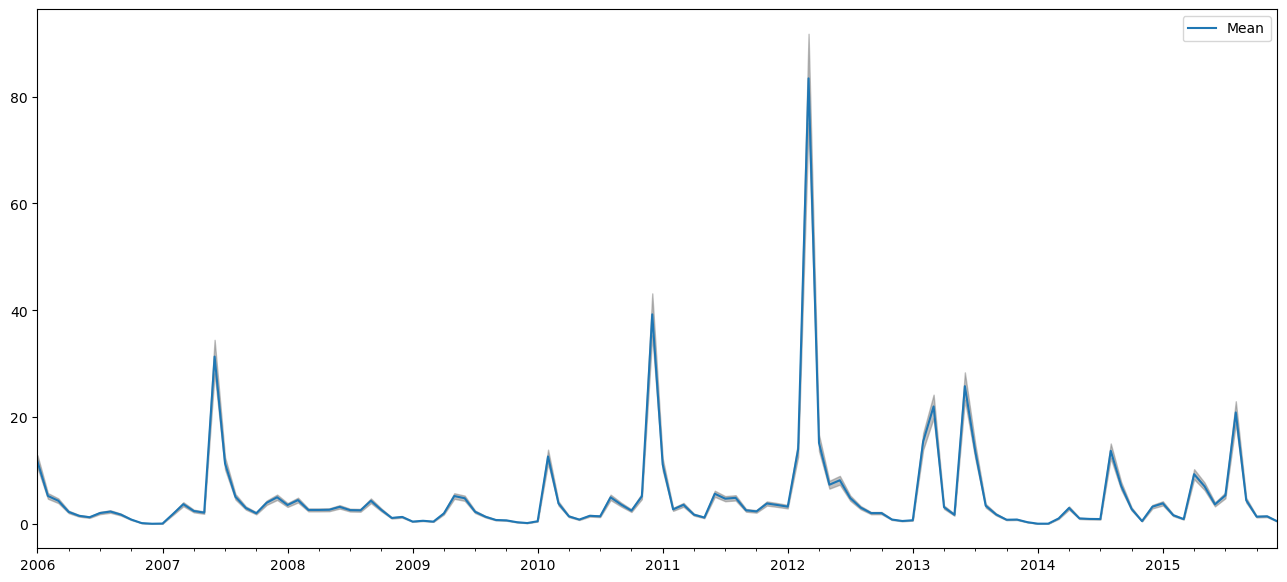

In [11]:
# Plot monthly mean and uncertainty interval (+-sigma) of river discharge
df_meed['Low_int'] = df_meed['Discharge'] - np.sqrt(var)
df_meed['High_int'] = df_meed['Discharge'] + np.sqrt(var)
fig, ax = plt.subplots(figsize=(16,7))
df_meed['Discharge'].plot(ax =ax , label = 'Mean')
ax.fill_between(df_meed.index, df_meed['Low_int'], df_meed['High_int'], color='grey', alpha=0.5)
ax.legend()
plt.show()


#### Water storage data

Monthly time-series of total water storage (anomalies relative to period 2004-2010) is provided in file `graceJPL.txt` (total water storage from the [JPL-Mascon GRACE](https://developers.google.com/earth-engine/datasets/catalog/NASA_GRACE_MASS_GRIDS_MASCON_CRI) dataset). This dataset also comes with an estimate of the standard error (square root of error variance) in the monthly data, provided in file `graceJPLerror.txt` (standard error of the GRACE data). Note that the GRACE data include months with missing data; these are indicated with a nodata value of -99999. 

In [12]:
# Read and plot the monthly storage data
df_mees = pd.read_csv('../../Data/StorageWaterLevel-212243.csv', index_col=0, usecols= [1,2], parse_dates=True)
df_mees.rename(columns={'Storage Water Level (m)': 'Storage'}, inplace  =True)

df_mees = df_mees['2006':'2015']
#df_mees.index = df_mees.index.date
df_mees = df_mees.resample('ME').mean()
df_mees


,Storage
Timestamp,
2006-01-31,97.685222
2006-02-28,99.491381
2006-03-31,98.994871
2006-04-30,98.275250
2006-05-31,97.465643
...,...
2015-08-31,115.330133
2015-09-30,116.432207
2015-10-31,116.201000


Since the GRACE dataset come with its own estimate of data error we will use it directly to get a Gaussian distribution $\mathcal{N}(S|m_S, v_S)$ for the uncertainty in water storage in each month. Here, $m_S$ is taken as the GRACE measurement and $v_S$ is set to the square of the GRACE standard error.

*Hint: to handle missing data values in the GRACE time-series you can for example set $m_S = 0$ and $v_S = 10^9$ (some large variance). Using a large variance represents a data value with extreme uncertainty, which is essentially equivalent to having no data for that month.*

In [13]:
# Compute monthly mean mS and variance vS of water storage
CV  =0.1
var = (CV* df_mees['Storage'])**2
df_mees['Var'] = var

df_mees



,Storage,Var
Timestamp,,
2006-01-31,97.685222,95.424026
2006-02-28,99.491381,98.985349
2006-03-31,98.994871,97.999845
2006-04-30,98.275250,96.580248
2006-05-31,97.465643,94.995515
...,...,...
2015-08-31,115.330133,133.010397
2015-09-30,116.432207,135.564588
2015-10-31,116.201000,135.026724


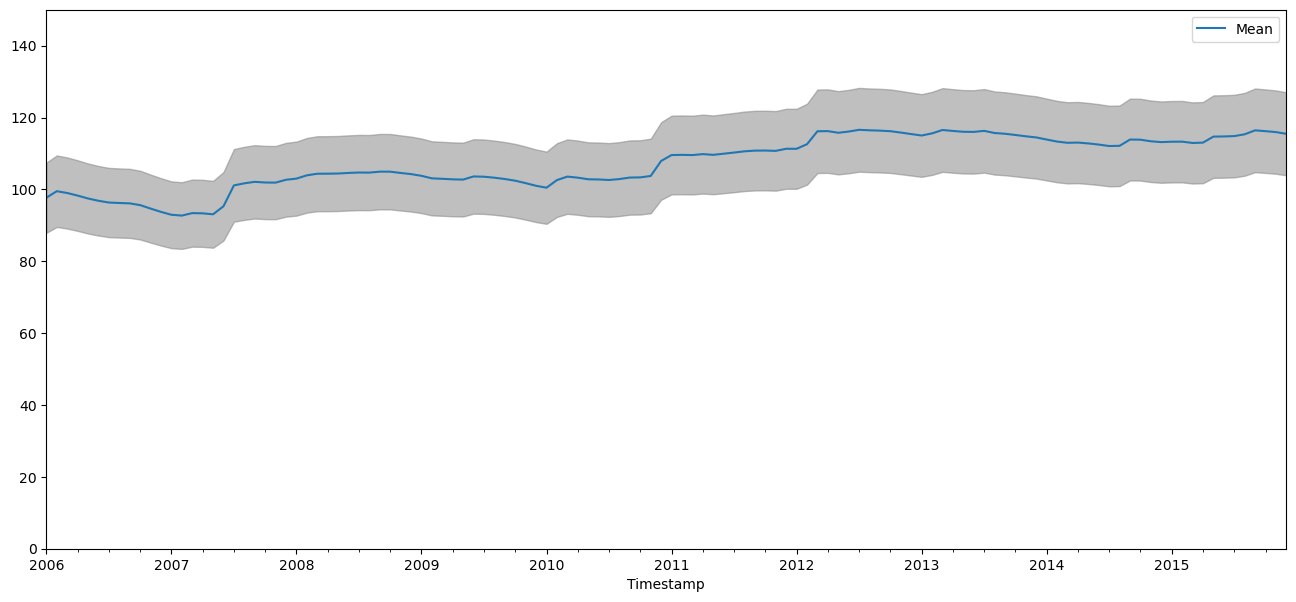

In [14]:
# Plot monthly mean and uncertainty interval (+-sigma) of water storage
# Plot monthly mean and uncertainty interval (+-sigma) of river discharge
df_mees['Low_int'] = df_mees['Storage'] - np.sqrt(df_mees['Var'])
df_mees['High_int'] = df_mees['Storage'] + np.sqrt(df_mees['Var'])
fig, ax = plt.subplots(figsize=(16,7))
df_mees['Storage'].plot(ax =ax , label = 'Mean')
ax.fill_between(df_mees.index, df_mees['Low_int'], df_mees['High_int'], color='grey', alpha=0.5)
ax.legend()
ax.set_ylim(0, 150)
plt.show()

# Part 2: Uncertainty propagation and Gaussian product 

Data assimilation relies on two basic building blocks:
* Uncertainty propagation: how to propagate uncertainty through a deterministic function, in our case the water balance (linear equation)?
* Gaussian product: how to combine two (or more) Gaussian distributions over the same variable?

This part explores these two building blocks and applies them to a water balance for a single month with noisy information on each water balance component in the form of Gaussian distributions:

$$\mathcal{N}(S_0|m_{S_0}, v_{S_0}), \mathcal{N}(P|m_{P}, v_{P}), \mathcal{N}(E|m_{E}, v_{E}), \mathcal{N}(Q|m_{Q}, v_{Q})$$
$$S = S_0 + P - E - Q$$
$$\mathcal{N}(S|m_{S}, v_{S})$$

Specifically, we aim to compute posterior distributions for individual water balance variables that combine information from the water balance and from the noisy measurement of that variable.

#### Uncertainty propagation

How to propagate uncertainty through a linear equation like the water balance? This can be done using basic formulas for the mean and variance of a linear combination of random variables. Remember that if $y = \sum_i a_i x_i$, then the mean of $y$ is $\sum_i a_i m_i$ and the variance of $y$ is $\sum_i a_i^2 v_i$, where $m_i$ and $v_i$ are mean and variance of each $x_i$, and each $a_i$ is a known constant. In the case of the water balance, each $a_i$ will be either $1$ or $-1$. These formulas apply if all $x_i$ are uncorrelated.

**Example 1**: given $m_P = 40.5$, $v_P = 10.2$, $m_E = 20.3$, $v_E = 10.9$, $m_Q = 5.3$, $v_Q = 0.5$, $m_{S_0} = 100$, $v_{S_0} = 100$, $m_S = 100$, $v_S = 100$. Apply uncertainty propagation and verify that the resulting distribution from water balance to $S$ has mean and variance equal to 114.9 and 121.6. Also verify that the resulting distribution from water balance to $P$ has mean and variance equal to 25.6 and 211.4. To apply uncertainty propagation to $P$, first rewrite the water balance so that $P$ is expressed as output on the left with the other variables on the right as input variables.

In [15]:
m_s0 = 100
m_p = 40.5
m_e = 20.3
m_q = 5.3
m_s = 100

v_s0 = 100
v_p = 10.2
v_e = 10.9
v_q = 0.5
v_s = 100

m_S = m_s0 + m_p - m_e - m_q
v_S = v_s0 + v_p + v_e + v_q

m_P = m_s + m_e + m_q - m_s0
v_P = v_s + v_e + v_q + v_s0

print(m_S, v_S)
print(m_P, v_P)


114.9 121.60000000000001
25.599999999999994 211.4


#### Gaussian product

How to combine two (or more) Gaussian distributions over the same variable? If we have two *independent* noisy sources of information for the same variable, in the form of two (Gaussian) distributions for that variable, then we can simply multiply these two (Gaussian) distributions. This is a basic rule of probability and also applies if the distributions are not Gaussian.

In the special case of two Gaussian densities, $\mathcal{N}(x|m_1,v_1)$ and $\mathcal{N}(x|m_2,v_2)$, for the same variable $x$, their product is proportional to a new Gaussian density for $x$:

$$ \mathcal{N}(x|m_1,v_1)\mathcal{N}(x|m_2,v_2) = \mathcal{N}(m_1|m_2,v_1+v_2)\mathcal{N}(x|m,v) $$

The first term on the right, $\mathcal{N}(m_1|m_2,v_1+v_2)$, is the proportionality constant (it's a number independent of $x$). The second term on the right, $\mathcal{N}(x|m,v)$, is the new Gaussian distribution for $x$ that combines information from the two Gaussians on the left. Its mean $m$ and variance $v$ are given by:

$$m = w_1 m_1 + w_2 m_2$$
$$v = w_1 v_1 = w_2 v_2$$

where weights $w_1 = \frac{v_2}{v_1 + v_2}$ and $w_2 = 1 - w_1 = \frac{v_1}{v_1 + v_2}$ have values between 0 and 1. These formulas can be derived by writing out the formulas for the two original Gaussian densities and [completing the square](https://en.wikipedia.org/wiki/Completing_the_square).

We see that the new Gaussian density for $x$ has a mean $m$ that lies in between the two original means $m_1$ and $m_2$, with interpolating weights $w_1$ and $w_2$ computed from the two original variances $v_1$ and $v_2$. If the two original Gaussians have the same noise level ($v_1 = v_2$), then $w_1 = w_2 = 0.5$ and the new mean is simply the average of the two original means. If on the other hand one Gaussian has more noise than the other, say $v_1 > v_2$, then according to the weight formulas we have $w_2 > w_1$, and thus the new mean will be closer to $m_2$ than to $m_1$, i.e. it is closer to the less noisy Gaussian. Intuitively this makes sense: when combining sources of information with different noise levels, the noisier (more uncertain) ones carry less weight in the final result. 

The formula for the new variance shows that, since weights $w_1$ and $w_2$ are less than 1, $v$ will be less than the two original variances, i.e. $v <= v_1$ and $v <= v_2$. The interpretation is that combining multiple (Gaussian!) sources of information reduces the uncertainty about variable $x$ compared to using a single source of information.

If there are more than two Gaussian sources of information (e.g. three noisy observations of the same variable), the formulas above can simply be repeated multiple times to process and incorporate each Gaussian in turn. The order in which this is done does not matter.

Complete the `gaussian_product` function below using the Gaussian product formula. The function takes in means and variances of two Gaussian distributions over the same variable, and returns mean and variance of the product of the two distributions. Test your function with the following inputs: $m_1=10.2$, $v_1=2$ , $m_2=5.6$, $v_2=1$; you should get $m=7.13$ and $v=0.67$.

In [16]:
def gaussian_product(m1, v1, m2, v2):
    # YOUR CODE HERE
    w1 = v2 / (v1+v2)
    w2 = v1 / (v1+v2)

    m = w1*m1 + w2*m2
    v = w1*v1
    
    return m, v

In [17]:
m1 = 10.2
m2 = 5.6
v1 = 2
v2 = 1

m, v = gaussian_product(m1, v1, m2, v2)

print(m,v)

7.133333333333333 0.6666666666666666


#### Posterior of S

To compute the posterior distribution of $S$, we combine information from the water balance (via uncertainty propagation of the noisy inputs through the water balance to output $S$) with the noisy measurement of $S$ (via Gaussian product).

**Example 2**: given same values as in Example 1, verify that the resulting posterior mean and variance of $S$ are equal to 106.72 and 54.87. If $v_S = 10^9$, verify that the resulting posterior mean and variance of $S$ are equal to 114.9 and 121.6. Explain the difference between these two cases.

In [18]:
m_Snew, v_Snew = gaussian_product(m_s0, v_s0, m_s0 + m_p - m_e - m_q, v_p + v_e + v_q + v_s0)

print(m_Snew, v_Snew)

106.72382671480145 54.87364620938629


#### Posterior of P

Similarly, to compute the posterior distribution of $P$, we combine information from the water balance with the noisy measurement of $P$.

**Example 3**: given the same numbers as in Example 1, verify that the resulting posterior mean and variance of $P$ are equal to 39.81 and 9.73 (for case $v_S = 100$) and 40.5 and 10.2 (for case $v_S = 10^9$). Again, explain the difference between these cases.

In [19]:
m_Pnew, v_Pnew = gaussian_product(m_p, v_p, m_s + m_e + m_q - m_s0, v_s + v_e + v_q + v_s0 )

print(m_Pnew, v_Pnew)

39.814169675090255 9.730505415162455


# Part 3: Kalman filtering and smoothing

In this last part, we implement a Kalman filtering-smoothing algorithm to compute posteriors for all variables using data from all months. For this, we use the monthly time-series of data error distributions computed in part 1 and combine it with the uncertainty propagation and Gaussian product steps from part 2.

The algorithm uses a forward loop over all months, starting in the first month, to propagate noisy information from earlier to later months. This is followed by a backward loop over all months, starting in the last month, to propagate noisy information from later to earlier months. This ensures we obtain the best water balance estimates in each month that combine all available data over the entire period.

In each month we have a water balance constraint $S = S_0 + P - E - Q$ and noisy data distributions in the form of Gaussian distributions $\mathcal{N}(P|m_P, v_P)$, $\mathcal{N}(E|m_E, v_E)$, $\mathcal{N}(Q|m_Q, v_Q)$, and $\mathcal{N}(S|m_S, v_S)$, where all means and variances have been calculated using the data error models in part 1 of the notebook. For the first month only, we also specify a Gaussian distribution $\mathcal{N}(S_0|m_{S_0}, v_{S_0})$ for initial storage.

`Forward loop`
The loop starts at the first month. In each month, do the following:

1. *Predict*: compute forward distribution to 𝑆, $\mathcal{N}(S|m_{\rightarrow S}, v_{\rightarrow S})$, by propagating input distributions of $S_0$, $P$, $E$, and $Q$ through the water balance model. This forward distribution incorporates all data from earlier months.

2. *Update*: compute filtering posterior of 𝑆 by combining (multiplying) the forward distribution to 𝑆 (from step 1) with the noisy data distribution of 𝑆. This multiplication essentially adds data for current month, so that the filtering posterior incorporates all data up to and including the current month. 

The filtering posterior becomes input distribution for $S_0$ in next month. See the lecture for a visual aid of these steps in the form of a `factor graph`. 

`Backward loop`
The loop starts at the last month. In each month, do the following:

1. Compute smoothing posterior of 𝑆 by combining (multiplying) the filtering posterior and the backward distribution to 𝑆, $\mathcal{N}(S|m_{S \leftarrow}, v_{S \leftarrow})$. The latter incorporates all data from later months. As the filtering posterior incorporates all data up to and including the current month, the smoothing posterior combines all data.

2. Compute posteriors of $𝑃$, $𝐸$, and $𝑄$ by combining (multiplying) their prior/data and backward distributions. The backward distribution is computed by uncertainty propagation through the water balance (backward direction).

3. Compute backward distribution to $𝑆_0$ by uncertainty propagation through the water balance (backward direction). This becomes the backward distribution to 𝑆 for previous month (used in step 1 in next iteration of backward loop).

Complete the `close_water_balance` function below that implements the Kalman filtering-smoothing algorithm. You only need to implement things where it says "YOUR CODE HERE", using uncertainty propagation and Gaussian product from part 2 of the notebook. In principle, no extra arrays are needed beyond what is already in the code. The function takes as input monthly time-series of mean and variances computed in part 1 of the notebook (the Gaussian distributions for the data errors), and it returns monthly time-series of posterior means and variances for all water balance variables (including posterior mean and variance for initial storage of the first month).

In [20]:
def close_water_balance(mP, vP, mE, vE, mQ, vQ, mS, vS):
    # Specify prior mean and variance for initial storage S0 (first month)
    mS0 = 0
    vS0 = 200 * 200#large variance to indicate large uncertainty
    
    # Initialize posteriors
    # We compute these in forward loop (filtering posteriors) and then update them in backward loop (smoothing posteriors)
    nt = len(mP)#number of months in time-series
    mPostP = np.zeros(nt)#posterior mean of precipitation in each month
    vPostP = np.zeros(nt)#posterior variance of precipitation in each month
    mPostE = np.zeros(nt)#etc...
    vPostE = np.zeros(nt)
    mPostQ = np.zeros(nt)
    vPostQ = np.zeros(nt)
    mPostS = np.zeros(nt)
    vPostS = np.zeros(nt)
    
    # Forward loop (filtering)
    for t in range(nt):
        # Step 1: predict - compute forward distribution to S
        # YOUR CODE HERE
        mToS = mS0 + mP[t] - mE[t]- mQ[t]
        vToS = vS0 + vP[t] + vE[t] + vQ[t]
        
        # Step 2: update - compute filtering posterior of S
        # YOUR CODE HERE
        mPostS[t], vPostS[t] = gaussian_product(mToS, vToS, mS[t], vS[t])
        mS0, vS0 = mPostS[t], vPostS[t]

    # Backward loop (smoothing)
    mToS, vToS = 0.0, 1e+9#represents backward distribution to S - initialize to wide Gaussian for last month

    for t in reversed(range(nt)):
        # Step 1: smoothing posterior of S
        # YOUR CODE HERE
        mPostS[t], vPostS[t] = gaussian_product(mPostS[t], vPostS[t], mToS, vToS)
        
        # Step 2: posteriors of P, E, and Q
        # YOUR CODE HERE
        mFromS, vFromS = gaussian_product(mS[t], vS[t],mToS, vToS)

        mtoP = mFromS + mE[t] + mQ[t] - mPostS[t-1]
        vtoP = vFromS + vE[t] + vQ[t] + vPostS[t-1]
        mtoE = mPostS[t-1] + mP[t] + -mQ[t] - mFromS
        vtoE = vFromS + vP[t] + vQ[t] + vPostS[t-1]
        mtoQ = mPostS[t-1] + mP[t] + -mE[t] - mFromS
        vtoQ = vFromS + vP[t] + vE[t] + vPostS[t-1]

        mPostP[t], vPostP[t] = gaussian_product(mP[t], vP[t], mtoP, vtoP)
        mPostE[t], vPostE[t] = gaussian_product(mE[t], vE[t], mtoE, vtoE)
        mPostQ[t], vPostQ[t] = gaussian_product(mQ[t], vQ[t], mtoQ, vtoQ)
        
        # Step 3: backward distribution to S0
        # YOUR CODE HERE
        mToS = mPostS[t] - mPostP[t] + mPostE[t] + mPostQ[t]
        vToS = vPostS[t] + vPostP[t] + vPostE[t] + vPostQ[t]
        
    # After backward loop: compute posterior mean and variance of S0 (initial storage first month)
    # YOUR CODE HERE
    mPostS0, vPostS0 = mPostS - mPostP + mPostE + mPostQ , vPostS+ vPostP + vPostE + vPostQ
    
    # Return final water balance estimates (posterior means and variances of monthly estimates)
    return mPostP, vPostP, mPostE, vPostE, mPostQ, vPostQ, mPostS, vPostS, mPostS0, vPostS0

Test and run your completed `close_water_balance` function. Verify that combining the monthly estimates of the different water balance variables (mPostP, mPostE, mPostQ, mPostS, mPostS0) gives a closing water balance in each month.

In [21]:
mPostP, vPostP, mPostE, vPostE, mPostQ, vPostQ, mPostS, vPostS, mPostS0, vPostS0 = close_water_balance(df_meep['Mean'], df_meep['Var'], df_meee['Mean'], df_meee['Var'],
                                                                                                        df_meed['Discharge'], df_meed['Var'], df_mees['Storage'],
                                                                                                        df_mees['Var'])

Check = mPostS-mPostS0 - mPostP + mPostE + mPostQ

Check

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_35348\3902718101.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mToS = mS0 + mP[t] - mE[t]- mQ[t]
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_35348\3902718101.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vToS = vS0 + vP[t] + vE[t] + vQ[t]
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_35348\3902718101.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

array([-3.55271368e-15,  0.00000000e+00, -3.55271368e-15,  8.88178420e-16,
       -1.11022302e-15, -5.10702591e-15, -8.88178420e-15,  2.66453526e-15,
        8.88178420e-15, -5.88418203e-15,  2.63677968e-15,  3.34454686e-15,
        1.74166237e-14,  6.43929354e-15, -4.88498131e-15,  5.32907052e-15,
        5.32907052e-15,  0.00000000e+00,  3.55271368e-15,  5.32907052e-15,
       -2.66453526e-15,  5.77315973e-15,  7.99360578e-15,  9.76996262e-15,
       -3.99680289e-15, -2.66453526e-15,  2.22044605e-15, -5.32907052e-15,
        3.99680289e-15,  3.10862447e-15, -3.99680289e-15, -2.66453526e-15,
        4.44089210e-15, -3.55271368e-15,  4.44089210e-15, -2.88657986e-15,
       -6.27276009e-15,  3.33066907e-15,  3.99680289e-15, -2.66453526e-15,
       -1.33226763e-14, -6.21724894e-15, -7.99360578e-15,  3.99680289e-15,
        6.66133815e-16,  1.33226763e-15, -3.44169138e-15,  2.88657986e-15,
        4.44089210e-16,  0.00000000e+00, -4.44089210e-16,  7.99360578e-15,
        5.88418203e-15, -

Finally, also plot monthly time-series of the posteriors for each variable. For example, this can be done by plotting the posterior mean and uncertainty interval (+-sigma). Adding the original observations to the same plot is also useful.

In [25]:
df_E

,212260,211008,215004
time,,,
2006-01-31,128.425754,139.146513,128.906223
2006-02-28,108.126005,106.709304,109.181806
2006-03-31,82.437573,98.628297,85.853501
2006-04-30,48.400538,44.850776,43.871230
2006-05-31,31.816548,27.309691,29.699223
...,...,...,...
2015-08-31,37.985674,44.226357,39.559099
2015-09-30,68.566155,78.596125,71.290359
2015-10-31,92.054335,121.618607,92.033905


In [22]:
def PlotPosterior(name, m, v, obs1, obs2, obs3):
    mu = m
    sigma = np.sqrt(v)
    lower = mu - sigma
    upper = mu + sigma
    plt.figure(figsize=(16,7))
    plt.fill_between(np.arange(len(lower)), lower, upper, color='grey', alpha=0.5)
    plt.plot(mu, 'k')
    plt.plot(np.ma.masked_values(obs1, -99999), 'r.')
    plt.plot(np.ma.masked_values(obs2, -99999), 'b.')
    plt.plot(np.ma.masked_values(obs3, -99999), 'g.')
    plt.ylabel(name)

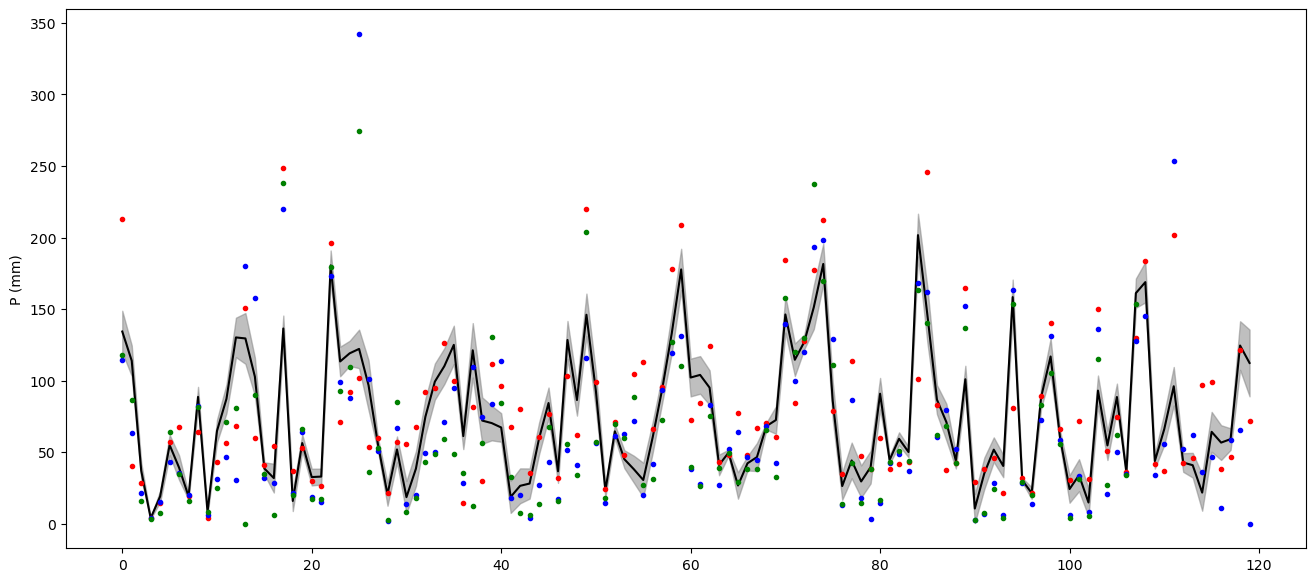

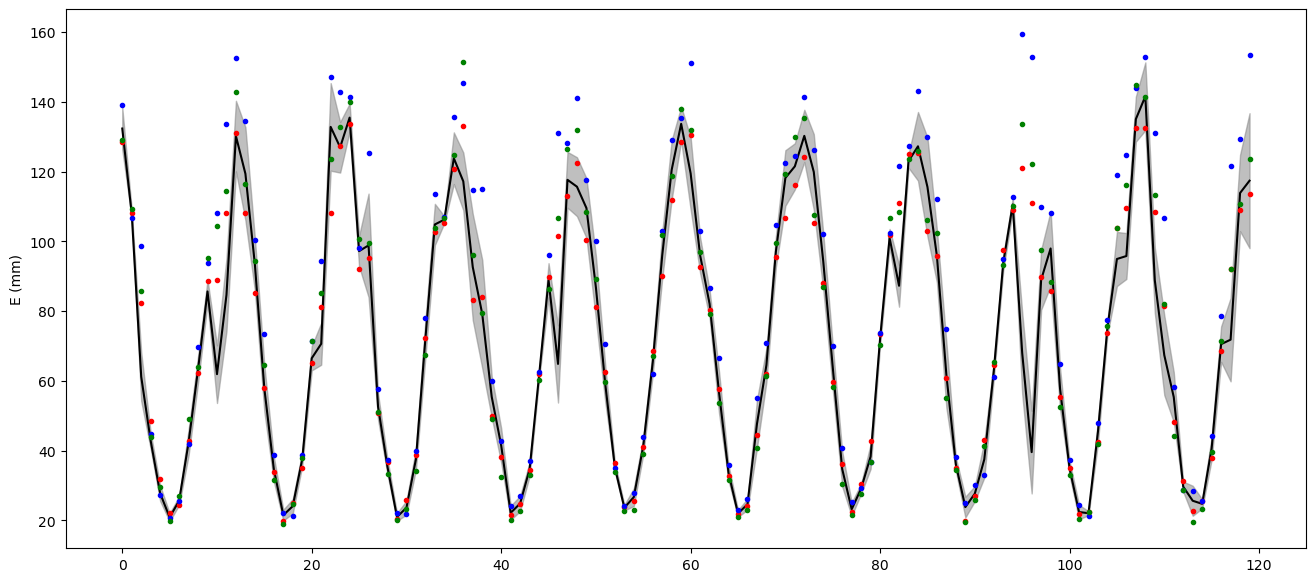

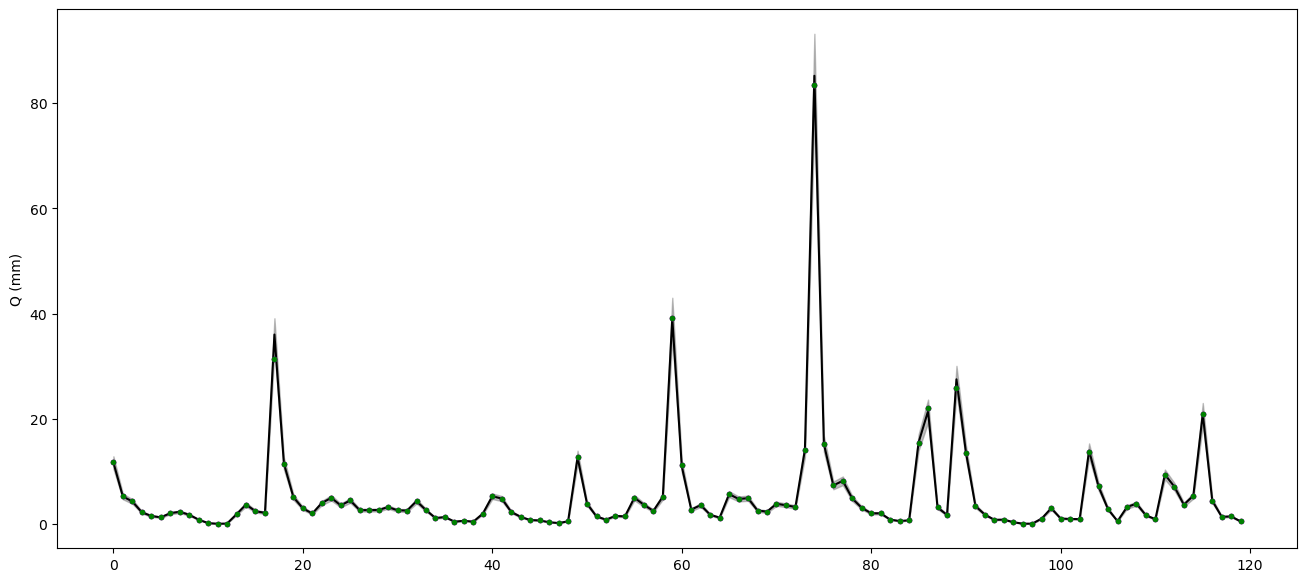

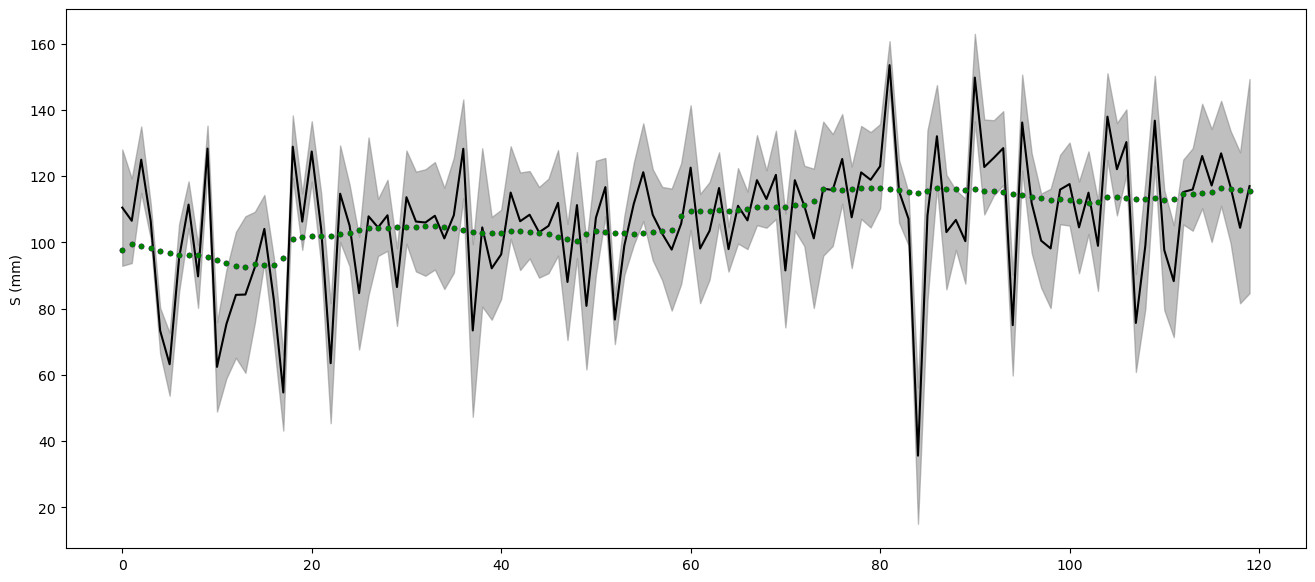

In [28]:
PlotPosterior("P (mm)", mPostP, vPostP, df_camel_month, df_monthly, df_hill_monthly)
PlotPosterior("E (mm)", mPostE, vPostE, df_E['212260'], df_E['211008'], df_E['215004'])
PlotPosterior("Q (mm)", mPostQ, vPostQ, df_meed['Discharge'], df_meed['Discharge'], df_meed['Discharge'])
PlotPosterior("S (mm)", mPostS0, vPostS0, df_mees['Storage'], df_mees['Storage'], df_mees['Storage'])
plt.show()

### Conclusion and further extensions
This completes the notebook!

The final estimated posteriors (and results of data assimilation in general) depend to a great extent on the assumptions that are made about uncertainty in the model and the data (see e.g. assumptions we made in part 1). This is still very much an open research problem. 

For example, a [recent paper](https://doi.org/10.1029/2020WR029071) proposed specific data error models for closing the water balance. The approach used in that paper follows a similar methodology as we used in this notebook, but with additional features:
* Adding non-negativity constraints on the water balance variables to prevent non-physical negative estimates. For this a more sophisticated version of Kalman smoothing is used that involves multiple forward-backward passes over the data (iterative smoothing).
* Using data error models that contain basin-specific parameters, so that each river basin can have its own specific set of data error models. These parameters are then also estimated from the data, together with all water balance variables. 

The complete tool developed in that paper is available at https://github.com/gschoups/BasinWaterBalance. 
